# Avellaneda and Stoikov model calibration

AvellanedaStoikov parameter calibration for gamma ray HFT trading bot

In [1]:
import numpy as np
import pandas as pd

import dask
import dask.dataframe as dd

import lightgbm as lgb
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
import math

from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='3GB')
# client


plt.rc('figure', figsize=(20, 5))

## Introduction

Gamma ray HFT trading bot uses the finite horizon Avellaneda and Stoikov model with the following formulation:

**assmue order arrial rate**
$$\lambda^a(\delta)=\lambda^b(\delta)=Ae^{-k\delta}$$

**reservation price**

$$r(s,t)=s-q\gamma\sigma^2(T-t)$$

**spread**
$$\delta=\delta^a+\delta^b=\gamma\sigma^2(T-t)+\frac{2}{\gamma}\ln(1+\frac{\gamma}{k})$$

**bid price**
$$r^b(s,q,t)=r(s,t)-\frac{1}{2}\delta$$

**ask price**
$$r^a(s,q,t)=r(s,t)+\frac{1}{2}\delta$$

**The following contents in this notebook will calibrate the following parameters**:

1. sigma
2. k
3. gamma

For more information you can refer to the original [paper](https://www.researchgate.net/publication/24086205_High_Frequency_Trading_in_a_Limit_Order_Book). It is worth noting that calibration of the above parameters are non-trivial, they are active research fields with various on going studies. This notebook only provide one (simple) method for calibrating the model.

## Playground

This is a implementation of the model in python, you can plug in different parameters and see the outputs of the model to get a tangible feeling of the model

In [2]:
T = 1.0
t = 0.0
dt = T - t
gamma = 0.1
sigma = 0.02
k = 0.1159
q = 0
s = 9500

r = s - q * gamma * sigma**2 * dt

# Reserve spread
r_spread = gamma * sigma**2 * dt +2 / gamma * math.log(1+gamma/k)

# optimal quotes
ra = r + r_spread/2
rb = r - r_spread/2
print("ask quote: ", ra)
print("bid quote", rb)

ask quote:  9506.220895871751
bid quote 9493.779104128249


## Trading data

For illustration purpose, we will only one day's XBTUSD quoting data and trading data. In practise you should use a much longer sample of historical prices and trades. You can get all historical data here: https://public.bitmex.com/

In [3]:
# print(pd.Timestamp(1581202802.895058, unit="s"))

quotes = dd.read_csv("./data/XBTUSD_quote_sample.csv", )
trades = dd.read_csv("./data/XBTUSD_trade_sample.csv")

# print(quotes.index)


# array_of_ts = [1581202802.895058, 1581202802.895058]

quotes_index = dd.to_datetime(quotes.timestamp, format="%Y-%m-%dD%H:%M:%S.%f000")
quotes = quotes.set_index(quotes_index, sorted=True)

trades_index = dd.to_datetime(trades.timestamp, format="%Y-%m-%dD%H:%M:%S.%f000")
trades = trades.set_index(trades_index, sorted=True)


# print(quotes.describe())

In [4]:
# calculate mid price by averaging best bid and best ask
# print(quotes.bidPrice + quotes.askPrice)

# quotes.loc[:, 'midPrice'] = (quotes.bidPrice + quotes.askPrice) / 2
quotes['midPrice'] = (quotes.bidPrice + quotes.askPrice) / 2
quotes.head()

,timestamp,bidSize,bidPrice,askPrice,askSize,midPrice
2020-02-09 00:00:02.895058,2020-02-09D00:00:02.895058000,355504,9908.0,9908.5,2899255,9908.25
2020-02-09 00:00:02.897041,2020-02-09D00:00:02.897041000,355504,9908.0,9908.5,2899257,9908.25
2020-02-09 00:00:03.314872,2020-02-09D00:00:03.314872000,355504,9908.0,9908.5,2903120,9908.25
2020-02-09 00:00:03.323900,2020-02-09D00:00:03.323900000,355504,9908.0,9908.5,2904620,9908.25
2020-02-09 00:00:03.325374,2020-02-09D00:00:03.325374000,355404,9908.0,9908.5,2904620,9908.25


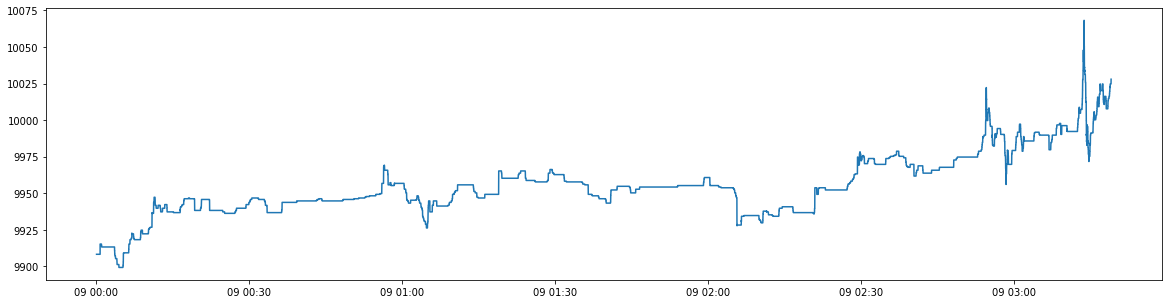

In [5]:
# reset the index to timestamp and plot the price change for the day
Xt = quotes.midPrice
plt.plot(Xt.compute())

## Parameter estimation: sigma

In this chapter we calibrate the model parameter sigma, which is measures the volitility of an assumed brownian motion. We use the first solution proposed here:
https://alexioannides.com/2019/01/18/stochastic-process-calibration-using-bayesian-inference-probabilistic-programs/

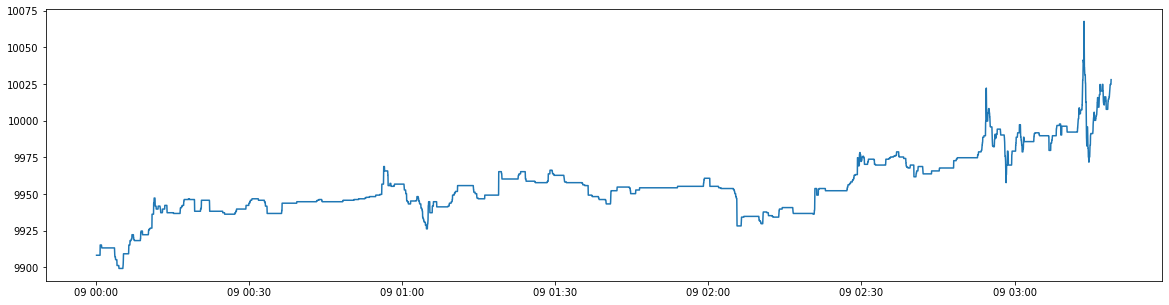

In [6]:
# resample prices with 1 second fixed interval
resample = Xt.resample('1S').last().bfill().compute()
plt.plot(resample)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='midPrice', ylabel='Density'>

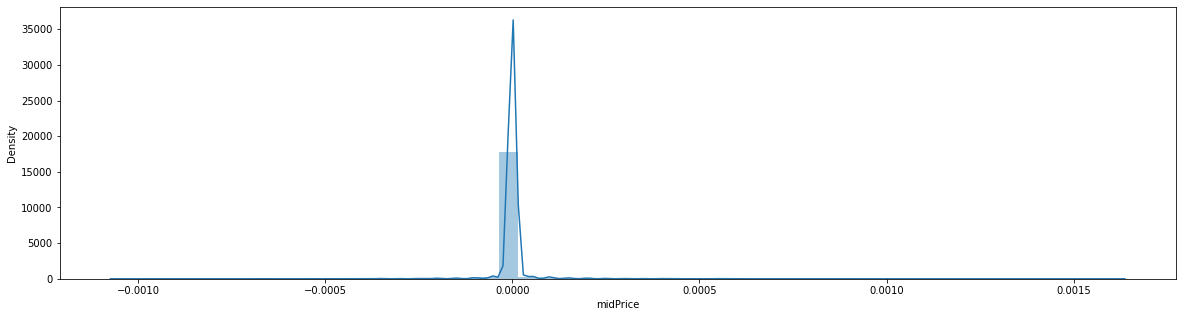

In [7]:
log_norm = np.log(resample).diff(1).dropna()
sns.distplot(log_norm)

In [8]:
# calculate deviation
sigma = log_norm.std() * np.sqrt(3600*24)
print(sigma)

0.01928833933814066


## Parameter estimation: k

Parameter k measures the probability of an order being executed at a given tick, here will estimate k by counting trades in **n** samples with each sample being a 10 seconds time period. For more information you can read Joaquin FERNANDEZ TAPIA's PhD thesis:
[Modeling, optimization and estimation for the on-line control of trading algorithms in limit-order markets](https://www.researchgate.net/publication/284900784_Modeling_optimization_and_estimation_for_the_on-line_control_of_trading_algorithms_in_limit-order_markets) Chapter 4

![captured liquidity](./footage/captured_liquidity.png)

### Average volume quantity

We will find the average marketable order size

In [9]:
# we use the median quantity as the average volume quantity
trades_filtered = trades[trades['size'] > 25].compute() # filter out small trades
trades_filtered['size'].describe()

count    2.616130e+05
mean     6.595870e+03
std      2.693212e+04
min      2.600000e+01
25%      7.800000e+01
50%      5.000000e+02
75%      3.600000e+03
max      3.897981e+06
Name: size, dtype: float64

So the average volume quantity is 50 percentile: 500

### Estimate trade intensity

In [10]:
# rounding util functions

def round_up(x, tick):
    remainder = x % tick
    if remainder == 0:
      return x
    else:
      return x + tick - remainder

def round_down(x, tick):
    remainder = x % tick
    if remainder == 0:
      return x
    else:
      return math.floor(x / tick) * tick

In [11]:
# TODO: this part is really slow, could be more efficient(pre-allocate memory) and use parallel processing to speed things up

# sample time window in seconds
dT = 10
# number of samples
n = 0
# initial timestamp
T0 = quotes.head(1).index.values[0]
# end timestamp
T_final = quotes.tail(1).index.values[0]
# min tick size
tick = 0.5
# measured spread range
r = 40 # 40*0.5=20

T_start = T0
T_end = T_start + pd.Timedelta(seconds=dT)

ask_side_hits = np.array([])
bid_side_hits = np.array([])

while T_end < T_final:

    # print("Processing timestamp: ", T_start)
    # reference price S(t)
    St = quotes.loc[(quotes.index >= T_start)].compute().iloc[0,:].midPrice
    # ask side
    St_ask = round_down(St, tick)
    # get marketable bids
    criteria_1 = (trades_filtered.index >= T_start) # timestamp later than T_start
    criteria_2 = (trades_filtered.index < T_end) # timestamp ealier than T_end
    criteria_3 = (trades_filtered.side == 'Buy') # side is "Buy"
    criteria_4 = (trades_filtered.price > St_ask) # price must be higher than St_ask
    criteria_5 = (trades_filtered.price <= St_ask + (r * tick)) # price must be lower than the measured spread range
    m_bids = trades_filtered.loc[criteria_1 & criteria_2 & criteria_3 & criteria_4 & criteria_5]

    if len(m_bids.index) > 0:
        # count ticks where marketable orders "hit"
        hits = np.floor_divide(np.subtract(m_bids.price.unique(), St_ask), tick)
        ask_side_hits = np.hstack([ask_side_hits, hits])

    # bid side
    St_bid = round_up(St, tick)
    # get marketable asks
    criteria_1 = (trades_filtered.index >= T_start) # timestamp later than T_start
    criteria_2 = (trades_filtered.index < T_end) # timestamp ealier than T_end
    criteria_3 = (trades_filtered.side == 'Sell') # side is "Sell"
    criteria_4 = (trades_filtered.price < St_bid) # price must be lower than St_bid
    criteria_5 = (trades_filtered.price >= St_bid - (r * tick)) # price must be higher than the measured spread range
    m_asks = trades_filtered.loc[criteria_1 & criteria_2 & criteria_3 & criteria_4 & criteria_5]

    if len(m_asks.index) > 0:
        # count ticks where marketable orders "hit"
        hits = np.floor_divide(np.subtract(m_asks.price.unique(), St_bid), -tick)
        bid_side_hits = np.hstack([bid_side_hits, hits])

    T_start = T_start + pd.Timedelta(seconds=dT)
    T_end = T_end + pd.Timedelta(seconds=dT)
    n = n + 1
    # break

print('done with {0} samples'.format(n))

done with 1193 samples


In [12]:
unique, counts = np.unique(ask_side_hits, return_counts=True)
ask_side_hits_agg = np.asarray((unique, counts)).T
unique, counts = np.unique(bid_side_hits, return_counts=True)
bid_side_hits_agg = np.asarray((unique, counts)).T
df_ask = pd.DataFrame(ask_side_hits_agg, columns=['tick', 'hits'])
df_bid = pd.DataFrame(bid_side_hits_agg, columns=['tick', 'hits'])
df_ask = df_ask.div([1, n])
df_ask = df_ask.rename(columns = {'hits': 'intensity'})
df_bid = df_bid.div([1, n])
df_bid = df_bid.rename(columns = {'hits': 'intensity'})

In [13]:
## you might want to save your hard calculated results
# df_ask.to_csv('ask_side_intensity.csv')
# df_bid.to_csv('bid_side_intensity.csv')

<AxesSubplot:xlabel='tick'>

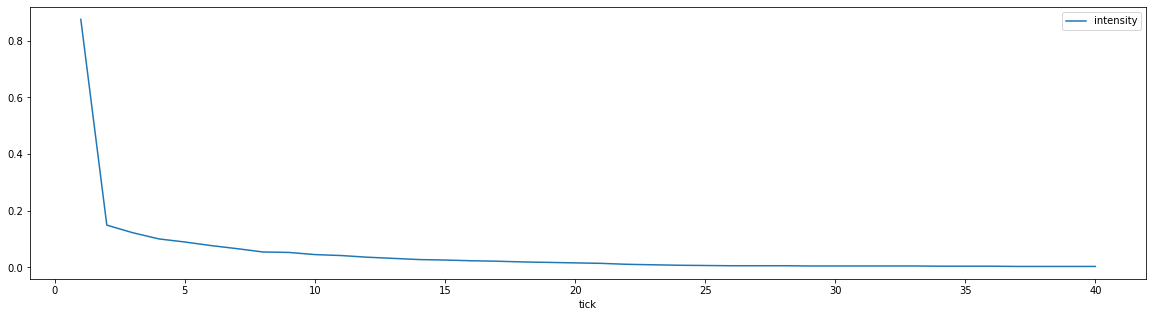

In [14]:
df_ask.plot(x='tick', y=['intensity'])

<AxesSubplot:xlabel='tick'>

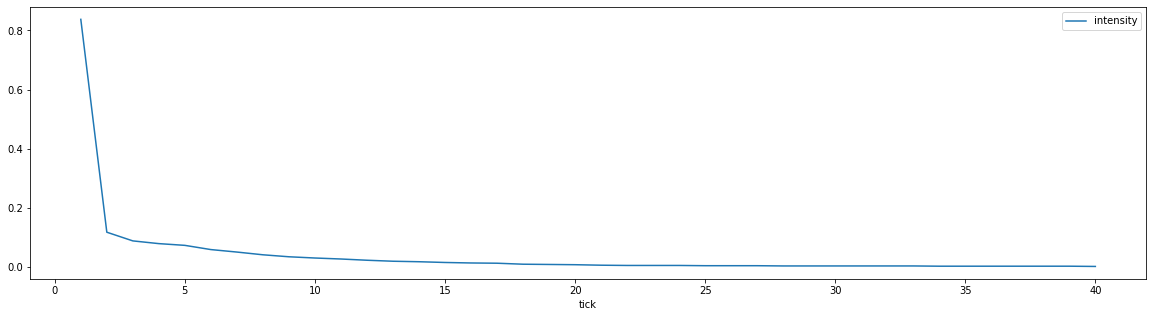

In [15]:
df_bid.plot(x='tick', y=['intensity'])

In [16]:
# estimate k using linear regression
from sklearn.linear_model import LinearRegression
X = df_ask.tick.to_numpy()[:, np.newaxis]
y = np.log(df_ask.intensity)
reg = LinearRegression().fit(X, y)
print('r: ', reg.score(X, y))
k_ask = - reg.coef_[0]
A_ask = np.exp(reg.intercept_)
print('k: ', k_ask)
print('A: ', A_ask)

r:  0.9221156476101634
k:  0.10965956263390748
A:  0.15538417836627455


In [17]:
X = df_bid.tick.to_numpy()[:, np.newaxis]
y = np.log(df_bid.intensity)
reg = LinearRegression().fit(X, y)
print('r: ', reg.score(X, y))
k_bid = - reg.coef_[0]
A_bid = np.exp(reg.intercept_)
print('k: ', k_bid)
print('A: ', A_bid)

r:  0.8681131370647195
k:  0.10474483245697357
A:  0.1025528765654139


In [18]:
k = np.mean([k_bid, k_ask])
A = np.mean([A_bid, A_ask])
print('k mean: ', k)
print('A mean: ', A)

k mean:  0.10720219754544053
A mean:  0.12896852746584422


In [19]:
# A*np.exp(-k * np.arange(40.))
df_ask.loc[:, 'estimated'] = A*np.exp(-k * np.arange(40.))

<AxesSubplot:xlabel='tick'>

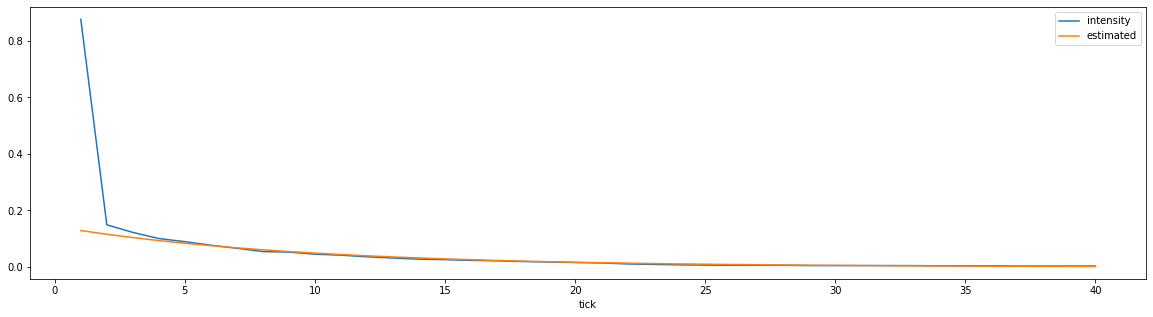

In [20]:
df_ask.plot(x='tick', y=['intensity', 'estimated'])

In this case lower tick intensity are significantly under-estimated

## Parameter estimation: gamma

Gamma is a parameter for market maker's risk aversion factor, there is no easy way which can be detailed in this notebook. It seems this parameter comes from 3 approaches:

- empirical: in lots of literatures this value is 0.1
- machine (reinforcement) learning: see this [repo](https://github.com/im1235/ISAC)

Let me know if you have better findings :D